In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import math

### Load the data

In [2]:
d = loadmat('LGN_FFdata.mat')

In [3]:
d.keys()

dict_keys(['__header__', '__version__', '__globals__', 'DTstim', 'FFspks', 'FFstim', 'FFstimR', 'FFspksR'])

In [388]:
spiks = d['FFspks'][0] # number is number of seconds from the start for that spike
#stims = d['FFstim'][:-1] # TODO: there seems to be an extra 0 at the end of stims which is messing stuff up
stims = d['FFstim'] # TODO: there seems to be an extra 0 at the end of stims which is messing stuff up
dt = d['DTstim'][0] # time between each stimulus
# Firing rate is probability of firing for a stimulus
# average rate is a rate parameter for a Poisson process

In [389]:
stims # this is the intensity of the stimulus at this presentation

array([[-1.66558397],
       [ 0.125332  ],
       [ 0.28767601],
       ...,
       [-0.72446799],
       [-0.068865  ],
       [ 0.        ]])

14391


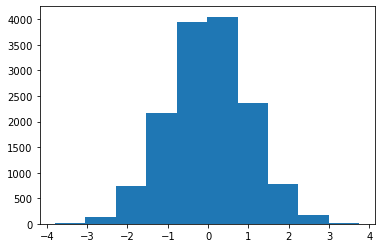

In [390]:
plt.hist(stims)
print(len(stims))

In [391]:
len(stims) * dt

array([120.00814013])

In [392]:
t = 0.02
stim_idx = math.floor(t/dt) # the stimulus trial at any time
# get multiple columns in the vector by passing in multiple indices

# we can also do some interesting matrix math to make it simpler to do


In [393]:
min(spiks), max(spiks)

(0.06999999999999318, 120.00457499999999)

### A. Calculate the average stimulus for all spike times.

In [394]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims):
    max_stim = len(stims) * dt
    # put a tiny amount of extra time at the end of the bin to make sure that we include the extreme times
    epsilon = dt / 2
    return np.histogram(spiks, bins=np.arange(0, max_stim+epsilon, dt), range=(0, max_stim))[0]

In [395]:
spiks_per_stim = associate_spiks_to_stims(spiks, stims)
len(stims), len(spiks_per_stim)

(14391, 14391)

In [396]:
# Whenever there is a spike,
# sum the stimulus values and divide by the number of spikes
stim_sum = 0.
stim_count = 0.
for stim_idx, spik in enumerate(spiks_per_stim):
    if spik > 0:
        stim_sum += spik * stims[stim_idx]
        # we want to multiply the stims by the number of spiks it elicited
        stim_count += spik
avg_stim_when_spiks = stim_sum / stim_count

In [397]:
avg_stim_when_spiks[0]
# should be 0.059 or so

0.05954608809527265

In [398]:
np.min(stims), np.max(stims)

(-3.7988569736480713, 3.747612953186035)

### B. Calculate and plot the full spike-triggered average of the neuron.

In [399]:
dt # the time steps between the stimulus presentations

array([0.00833911])

In [400]:
# moving window across the binned spikes, in 100ms (.1) bins
window_size = math.ceil(.1 / dt)

In [401]:
# slide the window over the stims
stas = []
for stim_idx in range(window_size, len(stims)):
    # get the average over the last <window_size> from the current stim
    stim_sum = 0.
    stim_count = 0.
    for stim, spik in zip(stims[stim_idx-window_size:stim_idx], spiks_per_stim[stim_idx-window_size:stim_idx]):
        if spik > 0:
            stim_sum += spik * stim
            stim_count += spik
    if stim_count > 0:
        avg_stim_when_spiks = (stim_sum / stim_count)[0]
    else:
        avg_stim_when_spiks = 0
    stas.append(avg_stim_when_spiks)

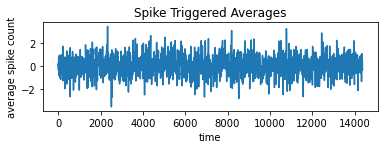

In [402]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(211)
ax1.set_xlabel('time')
ax1.set_ylabel('average spike count')
ax1.set_title('Spike Triggered Averages')
ax1.plot(stas)

### NOTE: this is nothing

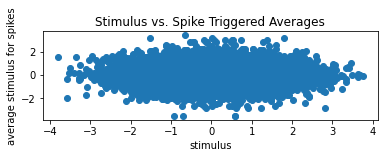

In [403]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax2 = fig.add_subplot(211)
ax2.set_xlabel('stimulus')
ax2.set_ylabel('average stimulus for spikes')
ax2.set_title('Stimulus vs. Spike Triggered Averages')
ax2.scatter(stims[window_size:], stas)

# Problem Set, done with matrices to make it simpler

## 1. Temporal receptive field of a neuron

### A. Average stimulus value for all spike times

In [404]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims):
    max_stim = len(stims) * dt
    # put a tiny amount of extra time at the end of the bin to make sure that we include the extreme times
    epsilon = dt / 2
    return np.histogram(spiks, bins=np.arange(0, max_stim+epsilon, dt), range=(0, max_stim))[0]

# combine the spiks and stims by as columns
def merge_spiks_and_stims(spiks, stims):
    spiks_per_stim = associate_spiks_to_stims(spiks, stims)
    return np.column_stack([stims.flatten(), spiks_per_stim])

In [405]:
merged = merge_spiks_and_stims(spiks, stims)

In [406]:
len(merged), merged

(14391,
 array([[-1.66558397,  0.        ],
        [ 0.125332  ,  0.        ],
        [ 0.28767601,  0.        ],
        ...,
        [-0.72446799,  0.        ],
        [-0.068865  ,  0.        ],
        [ 0.        ,  1.        ]]))

In [407]:
# average stimulus for all spike times
np.sum(merged[:,0] * merged[:,1]) / np.sum(merged[:,1])

0.05954608809527265

### Updates

In [408]:
# S0 is stimulus at spike times
# S1 is stimulus shifted 1 time lag (dt)
# S2 is stimulus shifted 2 time lags

### B. STA of the neuron

In [409]:
# moving window across the binned spikes, in 100ms (.1) bins
num_lags = math.ceil(.1 / dt)
num_lags

12

In [410]:
# shifts vector by the amount (shift can be positive or negative)
# fills the empty elements with zeros
def shift_vector(vector, shift):
    if shift > len(vector):
        shift = len(vector)
    elif shift < 0 and abs(shift) > len(vector):
        shift = -len(vector)
    
    if shift > 0:
        shifted = np.concatenate((np.zeros((shift)), vector[:-shift]), axis=None)
    elif shift < 0:
        shifted = np.concatenate((vector[abs(shift):], np.zeros((abs(shift)))), axis=None)
    else:
        shifted = vector
    
    return shifted

In [411]:
a = [1, 2, 3, 4, 5]
shift_vector(a, -3)

array([4., 5., 0., 0., 0.])

In [412]:
def calc_sta(merged, num_lags):
    sta = []
    for lag in range(0, num_lags):
        lagged_stim = shift_vector(merged[:,0], lag)
        sta.append(np.sum(lagged_stim * merged[:,1]) / np.sum(merged[:,1]))
    sta = np.array(sta)
    return sta

In [413]:
sta = calc_sta(merged, num_lags=12)
len(sta), sta

(12,
 array([ 0.05954609,  0.00736425,  0.01464575,  0.29132787,  0.77145262,
        -0.77350106, -0.40184529,  0.00930294, -0.13743719,  0.01446317,
         0.0745255 ,  0.12431743]))

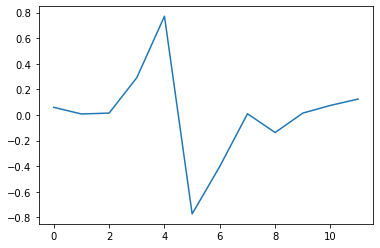

In [414]:
plt.plot(sta)

## 2. Calculating the spiking nonlinearity

### A. Calculate the stimulus convolved with the receptive field

In [415]:
# slide the STA filter over the stimulus,
# each stimulus value becomes a dot product of a length-12 sliding window and the filter

In [416]:
# it looks like if we divide the vector by its standard deviation, it has a std of 1
# TODO: figure out why this is the case
normalized_sta = sta / np.std(sta)

In [417]:
def kernel_response(stims, kernel):
    # pad the stims with zeros to be able to use the kernel from the start of the stims
    padded_stims = np.concatenate((np.zeros((len(kernel)-1)), stims), axis=None)
    
    # slide the window over the stims
    # TODO: change to the matrix method for better bookkeeping
    filtered_stims = []
    for i in range(len(kernel), len(padded_stims)+1):
        filtered_stims.append(np.dot(padded_stims[i-len(kernel):i], kernel))
    return np.array(filtered_stims)

In [418]:
# test that the kernel response does what we expect in the happy path
def test_kernel_response_happy():
    test_kernel = np.array([0, 0.5, 1])
    test_stims = np.array([1, 2, 4, 2, 4, 6])
    
    return kernel_response(test_stims, test_kernel)

test_kernel_response_happy()

array([1. , 2.5, 5. , 4. , 5. , 8. ])

In [455]:
def g_convolve( s, k ):
    # pad to make causal
    k2 = np.zeros(len(k)*2-1)
    k2[len(k)-1:] = [i for i in k]
    g = np.convolve( s, k2, mode='same')
    return g 

In [456]:
# test that the g_convolve does what we expect in the happy path
def test_g_convolve_happy():
    test_kernel = np.array([0, 0.5, 1])
    test_stims = np.array([1, 2, 4, 2, 4, 6])
    
    return g_convolve(test_stims, test_kernel)

test_g_convolve_happy()

array([0. , 0.5, 2. , 4. , 5. , 4. ])

In [459]:
stims.shape, normalized_sta.shape

((14391, 1), (12,))

In [468]:
filtered_stims = g_convolve(stims[:,0], normalized_sta)

In [473]:
# remove negative values from the filter response
nonneg_filtered_stims = list(map(lambda x: x if x >= 0 else 0, filtered_stims))

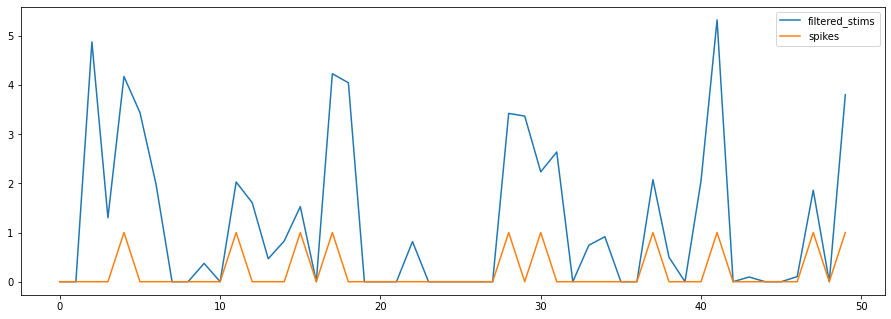

In [474]:
axt = plt.axes([1, 1, 2, 1])
#axt.plot(stims[50:100], label='stims')
#axt.plot(filtered_stims[50:100], label='filtered_stims')
axt.plot(nonneg_filtered_stims[50:100], label='filtered_stims')
axt.plot([r for s,r in merged[50:100]], label='spikes')
axt.legend()
plt.show()

### B. Calculate the histogram for the value of the filtered stimulus

In [475]:
histb = np.histogram(filtered_stims, bins=np.arange(-6, 6, 0.2))[0]

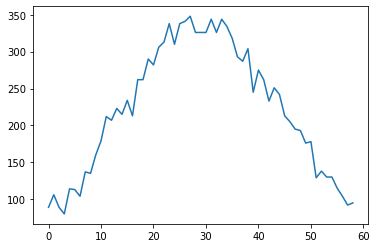

In [476]:
plt.plot(histb)

### C. Calculate the histogram for the value of the filtered stimulus for just the spike times

In [477]:
# filter the filtered_stims for just when there is a spike
indices_when_spiking = (merged[:,1] > 0).nonzero()[0]
indices_when_spiking

array([    8,    16,    23, ..., 14377, 14383, 14390])

In [478]:
filtered_stims_when_spiking = filtered_stims[indices_when_spiking]
histc = np.histogram(filtered_stims_when_spiking, bins=np.arange(-6, 6, 0.2))[0]

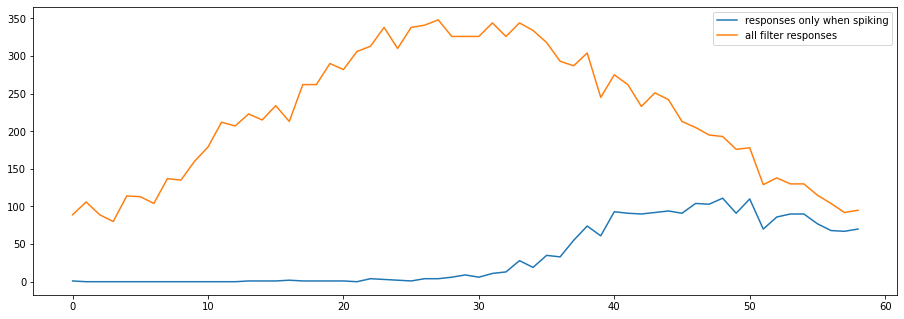

In [479]:
axc = plt.axes([1, 1, 2, 1])
axc.plot(histc, label='responses only when spiking')
axc.plot(histb, label='all filter responses')
axc.legend()
plt.show()

### D. Plot the spiking nonlinearity

In [480]:
len(histb), len(histc)

(59, 59)

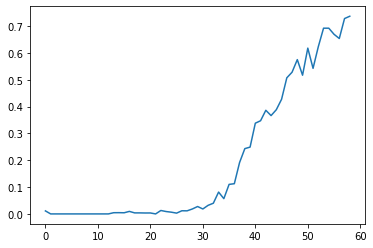

In [481]:
plt.plot(histc / histb)

## 3. Model Predictions and Cross-Validation

In [482]:
d['FFstimR']

array([[-0.36726299],
       [-1.43565404],
       [ 0.39810801],
       ...,
       [-0.14322101],
       [-1.12856805],
       [ 0.295412  ]])

In [483]:
d['FFspksR']

array([[ 0.01605,  0.01745,  0.0192 , ...,  9.95055,  9.99795, -1.     ]])

### Data loading and some analysis

In [484]:
len(stimsr), min(stimsr), max(stimsr)

(1200, -3.8369359970092773, 3.508730888366699)

In [485]:
# the stims are the same for each trial?
stimsr = d['FFstimR'][:,0]
stimsr

array([-0.36726299, -1.43565404,  0.39810801, ..., -0.14322101,
       -1.12856805,  0.295412  ])

In [486]:
# split the trials into rows, using -1 as the flag variable
spiksr = []
spikr = []
for x in d['FFspksR'][0]:
    if x == -1:
        spiksr.append(np.array(spikr))
        spikr = []
        continue
    spikr.append(x)

In [487]:
len(spiksr) # number of repeated trials

64

In [488]:
spiks_per_stim = associate_spiks_to_stims(spiksr[0], stimsr)
print(len(spiks_per_stim), len(stimsr))
print(stimsr)
print(spiks_per_stim)

1200 1200
[-0.36726299 -1.43565404  0.39810801 ... -0.14322101 -1.12856805
  0.295412  ]
[0 1 4 ... 0 1 0]


In [489]:
print('dt')
print(dt)

print('Maximum stim time')
print(str(dt * len(stimsr)))

print('Maximum spike time in trial 0')
print(str(max(spiksr[0])))

dt
[0.00833911]
Maximum stim time
[10.00693268]
Maximum spike time in trial 0
9.995800000000003


In [517]:
# assuming the stimsr are reused per trial, lets calculate the sta for each trial

# 1. merge the stimsr and spiksr for each trial
mergedrs = []
for spiks in spiksr:
    mergedrs.append(merge_spiks_and_stims(spiks, stimsr))
mergedrs = np.array(mergedrs)
    
# 2. calculate the sta for each trial
stasr = []
for mergedr in mergedrs:
    stasr.append(calc_sta(mergedr, 12))

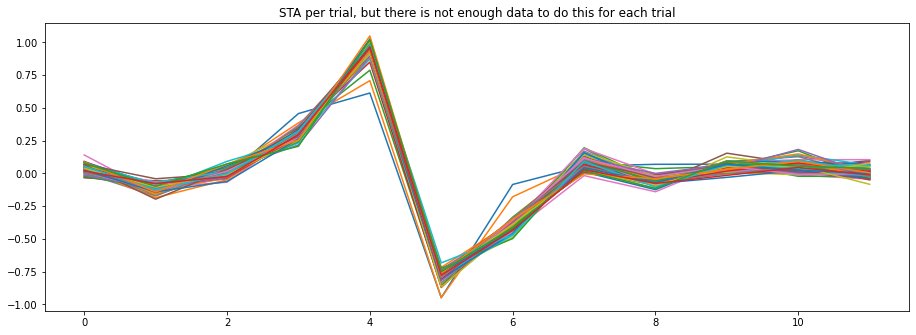

In [518]:
axc = plt.axes([1, 1, 2, 1])
axc.set_title('STA per trial, but there is not enough data to do this for each trial')
for i, star in enumerate(stasr):
    axc.plot(star, label=str(i))
plt.show()

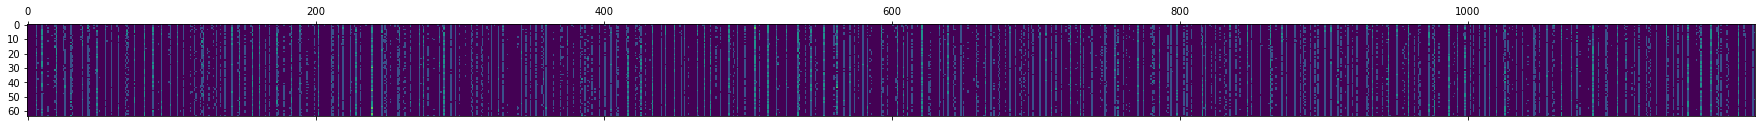

In [533]:
# plot the spiking raster
axraster = plt.axes([1, 1, 4, 1])
axraster.matshow(mergedrs[:,:,1]) #just show the spike counts per trial
plt.show()

### A.

In [251]:
# calculate the neurons firing rate as a function of time, using a bin size DTstim
# r(t) = n_spk(t) / dt


In [ ]:
# plot the firing rate between 800ms and 1000ms, vertical axis units in Hz
